# Step 1: Environment Setup



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

In [3]:
# Create Spark session for the analysis
# 4GB driver memory to handle the large dataset
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Weather Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark session created successfully!")
print(f"Spark version: {spark.version}")

# This will be used throughout the analysis for data processing and ML

Spark session created successfully!
Spark version: 4.0.1


# Step 2: Data Loading

Now I'll load both datasets. The location dataset contains information about the districts, and the weather dataset contains the meteorological data for Sri Lanka from 2010-2024 covering 27 districts. Loading both will allow me to join them and provide better context in the analysis.

In [4]:
# Load both datasets
# Location dataset contains district information
location_df = spark.read.csv("/content/drive/MyDrive/CW_DATASETS/locationData.csv", header=True, inferSchema=True)

# Weather dataset contains meteorological data
weather_df = spark.read.csv("/content/drive/MyDrive/CW_DATASETS/weatherData.csv", header=True, inferSchema=True)

print(f"Location dataset loaded! Total records: {location_df.count():,}")
print(f"Number of columns: {len(location_df.columns)}")
print(f"\nWeather dataset loaded! Total records: {weather_df.count():,}")
print(f"Number of columns: {len(weather_df.columns)}")

Location dataset loaded! Total records: 27
Number of columns: 8

Weather dataset loaded! Total records: 142,371
Number of columns: 21


# Step 3: Initial Data Exploration

Let me check what the data looks like - the schema, data types, and some sample records from both datasets.

In [5]:
# Check the location dataset structure
print("Location Dataset Schema:")
location_df.printSchema()
print("\nSample location data:")
location_df.show(5, truncate=False)

Location Dataset Schema:
root
 |-- location_id: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- elevation: integer (nullable = true)
 |-- utc_offset_seconds: integer (nullable = true)
 |-- timezone: string (nullable = true)
 |-- timezone_abbreviation: integer (nullable = true)
 |-- city_name: string (nullable = true)


Sample location data:
+-----------+---------+---------+---------+------------------+------------+---------------------+---------+
|location_id|latitude |longitude|elevation|utc_offset_seconds|timezone    |timezone_abbreviation|city_name|
+-----------+---------+---------+---------+------------------+------------+---------------------+---------+
|0          |6.924429 |79.90725 |4        |19800             |Asia/Colombo|530                  |Colombo  |
|1          |7.0650263|79.96622 |19       |19800             |Asia/Colombo|530                  |Gampaha  |
|2          |6.572935 |80.02519 |5        |19800     

In [6]:
# Check the weather dataset schema
print("Weather Dataset Schema:")
weather_df.printSchema()

# This helps me understand what type of data each column contains

Weather Dataset Schema:
root
 |-- location_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- weather_code (wmo code): integer (nullable = true)
 |-- temperature_2m_max (°C): double (nullable = true)
 |-- temperature_2m_min (°C): double (nullable = true)
 |-- temperature_2m_mean (°C): double (nullable = true)
 |-- apparent_temperature_max (°C): double (nullable = true)
 |-- apparent_temperature_min (°C): double (nullable = true)
 |-- apparent_temperature_mean (°C): double (nullable = true)
 |-- daylight_duration (s): double (nullable = true)
 |-- sunshine_duration (s): double (nullable = true)
 |-- precipitation_sum (mm): double (nullable = true)
 |-- rain_sum (mm): double (nullable = true)
 |-- precipitation_hours (h): integer (nullable = true)
 |-- wind_speed_10m_max (km/h): double (nullable = true)
 |-- wind_gusts_10m_max (km/h): double (nullable = true)
 |-- wind_direction_10m_dominant (°): integer (nullable = true)
 |-- shortwave_radiation_sum (MJ/m²): double (

In [7]:
# Look at first few rows of weather data
print("Sample weather data:")
weather_df.show(5, truncate=False)

# This gives me a sense of what actual values look like

Sample weather data:
+-----------+--------+-----------------------+-----------------------+-----------------------+------------------------+-----------------------------+-----------------------------+------------------------------+---------------------+---------------------+----------------------+-------------+-----------------------+-------------------------+-------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------+-------------------+
|location_id|date    |weather_code (wmo code)|temperature_2m_max (°C)|temperature_2m_min (°C)|temperature_2m_mean (°C)|apparent_temperature_max (°C)|apparent_temperature_min (°C)|apparent_temperature_mean (°C)|daylight_duration (s)|sunshine_duration (s)|precipitation_sum (mm)|rain_sum (mm)|precipitation_hours (h)|wind_speed_10m_max (km/h)|wind_gusts_10m_max (km/h)|wind_direction_10m_dominant (°)|shortwave_radiation_sum (MJ/m²)|et0_fao_evapotranspiration (mm)|sunrise     

In [8]:
# Get basic statistics for numerical columns
print("Summary statistics:")
weather_df.describe().show()

Summary statistics:
+-------+-----------------+--------+-----------------------+-----------------------+-----------------------+------------------------+-----------------------------+-----------------------------+------------------------------+---------------------+---------------------+----------------------+------------------+-----------------------+-------------------------+-------------------------+-------------------------------+-------------------------------+-------------------------------+
|summary|      location_id|    date|weather_code (wmo code)|temperature_2m_max (°C)|temperature_2m_min (°C)|temperature_2m_mean (°C)|apparent_temperature_max (°C)|apparent_temperature_min (°C)|apparent_temperature_mean (°C)|daylight_duration (s)|sunshine_duration (s)|precipitation_sum (mm)|     rain_sum (mm)|precipitation_hours (h)|wind_speed_10m_max (km/h)|wind_gusts_10m_max (km/h)|wind_direction_10m_dominant (°)|shortwave_radiation_sum (MJ/m²)|et0_fao_evapotranspiration (mm)|
+-------+-----

# Step 4: Data Quality Checks

Now I need to check for missing values and data quality issues. Missing data can affect my machine learning models, so it's important to identify them early.

In [9]:
# Check for missing values in the weather dataset
# Using PySpark's count() function to count non-null values
from pyspark.sql.functions import col, count, when, isnan, min, max, mean, stddev, abs

print("Checking for missing values in weather data...")
print("-" * 60)

# Count nulls for each column
null_counts = weather_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in weather_df.columns
]).collect()[0].asDict()

total_rows = weather_df.count()

print(f"Total rows: {total_rows:,}\n")
print("Missing values per column:")

# Show only columns with missing values
has_missing = False
for column, null_count in null_counts.items():
    if null_count > 0:
        percentage = (null_count / total_rows) * 100
        print(f"  {column}: {null_count:,} ({percentage:.2f}%)")
        has_missing = True

if not has_missing:
    print("  No missing values found in any column!")

print("-" * 60)

Checking for missing values in weather data...
------------------------------------------------------------
Total rows: 142,371

Missing values per column:
  No missing values found in any column!
------------------------------------------------------------


In [10]:
# Check for duplicate records
duplicate_count = weather_df.groupBy("location_id", "date").count() \
    .filter(col("count") > 1).count()
print(f"Duplicate records: {duplicate_count}")

Duplicate records: 0


In [11]:
# Check data range
print("=== Date Range ===")
weather_df.select(min("date"), max("date")).show()

=== Date Range ===
+---------+---------+
|min(date)|max(date)|
+---------+---------+
| 1/1/2010| 9/9/2023|
+---------+---------+



# Step 5: Joining Location and Weather Data

Location and weather datasets will be joined to add district names and location context to the weather data. This will make the analysis more meaningful by showing which districts have which weather patterns.

In [12]:
# Join location and weather data
# Using left join to keep all weather records and add location information
from pyspark.sql.functions import to_date, month, year

# Join on the common column between the two datasets
full_df = weather_df.join(location_df, on="location_id", how="left")

print("Datasets joined successfully!")
print(f"Total records after join: {full_df.count():,}")
print(f"Number of columns after join: {len(full_df.columns)}")

print("\nSample of joined data with location information:")
full_df.select("location_id", "city_name", "date", "temperature_2m_mean (°C)",
          "precipitation_hours (h)", "et0_fao_evapotranspiration (mm)").show(5, truncate=False)

Datasets joined successfully!
Total records after join: 142,371
Number of columns after join: 28

Sample of joined data with location information:
+-----------+---------+--------+------------------------+-----------------------+-------------------------------+
|location_id|city_name|date    |temperature_2m_mean (°C)|precipitation_hours (h)|et0_fao_evapotranspiration (mm)|
+-----------+---------+--------+------------------------+-----------------------+-------------------------------+
|0          |Colombo  |1/1/2010|26.0                    |0                      |4.61                           |
|0          |Colombo  |1/2/2010|26.3                    |1                      |3.91                           |
|0          |Colombo  |1/3/2010|26.0                    |3                      |3.66                           |
|0          |Colombo  |1/4/2010|25.7                    |0                      |3.75                           |
|0          |Colombo  |1/5/2010|24.6                   

# Step 6: Filtering May Data

I need to filter the data to only include May records, since the research question specifically asks about May conditions.

In [13]:
# Convert string to date and extract month
# The date format is "M/d/yyyy" (e.g., "5/1/2010")
full_df = full_df.withColumn("date_parsed", to_date(col("date"), "M/d/yyyy")) \
    .withColumn("month", month(col("date_parsed"))) \
    .withColumn("year", year(col("date_parsed")))

# Filter for May data only (month = 5)
may_df = full_df.filter(col("month") == 5)

print(f"May records: {may_df.count():,}")
print(f"Date range: {may_df.agg(min('year'), max('year')).collect()[0]}")

May records: 12,555
Date range: Row(min(year)=2010, max(year)=2024)


# Step 7: Data Cleaning

Handling missing values in the key columns needed for machine learning.

In [14]:
# Drop rows with missing values in key columns
# Since we have many records, losing a few thousand is acceptable
key_columns = ["precipitation_hours (h)", "sunshine_duration (s)", "wind_speed_10m_max (km/h)",
               "et0_fao_evapotranspiration (mm)", "temperature_2m_mean (°C)"]

print(f"Records before cleaning: {may_df.count():,}")

may_clean = may_df.dropna(subset=key_columns)

print(f"Records after cleaning: {may_clean.count():,}")
print(f"Records removed: {may_df.count() - may_clean.count():,}")

Records before cleaning: 12,555
Records after cleaning: 12,555
Records removed: 0


# Step 8: Feature Engineering

The sunshine duration is stored in seconds. It will be converted inot to hours so it makes sense and is comparable with other time-based metrics.

In [15]:
# Convert sunshine_duration from seconds to hours (more interpretable)
may_clean = may_clean.withColumn(
    "sunshine_hours",
    col("sunshine_duration (s)") / 3600
)

print("Feature engineering complete!")
print("\nSample of converted data:")
may_clean.select("sunshine_duration (s)", "sunshine_hours").show(5)

Feature engineering complete!

Sample of converted data:
+---------------------+------------------+
|sunshine_duration (s)|    sunshine_hours|
+---------------------+------------------+
|             40574.88|           11.2708|
|              39600.0|              11.0|
|             39191.48|10.886522222222224|
|             40046.57|11.124047222222222|
|             40047.19|11.124219444444446|
+---------------------+------------------+
only showing top 5 rows


# Step 9: Exploratory Data Analysis

Let me analyze the ET₀ distribution and understand what values constitute "low" versus "high" evapotranspiration.

In [16]:
# Analyze ET₀ distribution
print("ET₀ Distribution Statistics:")
may_clean.select("et0_fao_evapotranspiration (mm)").describe().show()

# Count records with ET₀ < 1.5mm (target threshold)
low_et0_count = may_clean.filter(col("et0_fao_evapotranspiration (mm)") < 1.5).count()
total_count = may_clean.count()

print(f"\nRecords with ET₀ < 1.5mm: {low_et0_count:,} ({low_et0_count/total_count*100:.2f}%)")
print(f"Records with ET₀ >= 1.5mm: {total_count - low_et0_count:,} ({(total_count - low_et0_count)/total_count*100:.2f}%)")

ET₀ Distribution Statistics:
+-------+-------------------------------+
|summary|et0_fao_evapotranspiration (mm)|
+-------+-------------------------------+
|  count|                          12555|
|   mean|              4.225671843886905|
| stddev|             1.1799446246284135|
|    min|                           0.59|
|    max|                           8.45|
+-------+-------------------------------+


Records with ET₀ < 1.5mm: 134 (1.07%)
Records with ET₀ >= 1.5mm: 12,421 (98.93%)


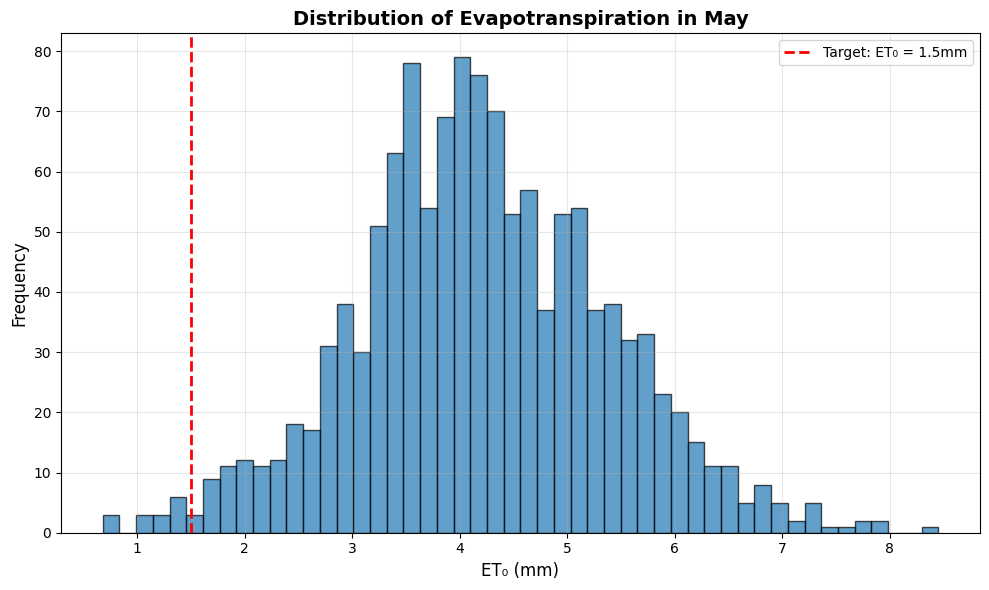

In [17]:
# Visualize ET₀ distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Sample for visualization (10% of data)
sample_df = may_clean.select("et0_fao_evapotranspiration (mm)", "precipitation_hours (h)",
                             "sunshine_hours", "wind_speed_10m_max (km/h)").sample(0.1).toPandas()

plt.figure(figsize=(10, 6))
plt.hist(sample_df["et0_fao_evapotranspiration (mm)"], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=1.5, color='red', linestyle='--', linewidth=2, label='Target: ET₀ = 1.5mm')
plt.xlabel('ET₀ (mm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Evapotranspiration in May', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Step 10: Feature Preparation for Machine Learning

Preparing features before training machine learning models. Relevant weather variables are selected and combined them into a single vector column as required by PySpark MLlib.

In [18]:
# Select features for the machine learning model
from pyspark.ml.feature import VectorAssembler, StandardScaler

# These are the input features I'll use to predict ET₀
all_features = [
    "precipitation_hours (h)",
    "sunshine_hours",
    "wind_speed_10m_max (km/h)",
    "temperature_2m_mean (°C)",
    "temperature_2m_max (°C)",
    "temperature_2m_min (°C)",
    "shortwave_radiation_sum (MJ/m²)",
    "elevation"
]

# VectorAssembler combines all features into a single column
assembler = VectorAssembler(inputCols=all_features, outputCol="raw_features")
df_assembled = assembler.transform(may_clean)

print(f"Features combined into vector: {len(all_features)} features")
print("Features selected:", ", ".join(all_features))

Features combined into vector: 8 features
Features selected: precipitation_hours (h), sunshine_hours, wind_speed_10m_max (km/h), temperature_2m_mean (°C), temperature_2m_max (°C), temperature_2m_min (°C), shortwave_radiation_sum (MJ/m²), elevation


In [19]:
# Standardize the features
# This ensures all features are on the same scale
scaler = StandardScaler(inputCol="raw_features", outputCol="features",
                        withStd=True, withMean=False)

# Fit the scaler on the data
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

print("Features standardized successfully")
print("This helps the ML models train better by putting all features on similar scales")

Features standardized successfully
This helps the ML models train better by putting all features on similar scales


In [20]:
# Split data into training and testing sets
# 80% for training, 20% for testing
# Using a random seed (42) so the split is reproducible
train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {train_data.count():,} records")
print(f"Test set: {test_data.count():,} records")

Training set: 10,128 records
Test set: 2,427 records


# Step 11: Training Machine Learning Models

Training multiple regression models using PySpark's MLlib library. Testing three different algorithms:

1. **Linear Regression** - Simple, interpretable baseline model
2. **Random Forest Regression** - Ensemble method that can capture non-linear patterns
3. **Gradient Boosted Trees** - Another powerful ensemble method

In [21]:
# Train Linear Regression model
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

print("Training Linear Regression model...")
lr = LinearRegression(featuresCol="features", labelCol="et0_fao_evapotranspiration (mm)",
                      maxIter=100, regParam=0.01)

lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

print("Linear Regression training complete!")

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="et0_fao_evapotranspiration (mm)",
                                     predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="et0_fao_evapotranspiration (mm)",
                                   predictionCol="prediction", metricName="r2")

lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)

print(f"RMSE: {lr_rmse:.4f}")
print(f"R²: {lr_r2:.4f}")

Training Linear Regression model...
Linear Regression training complete!
RMSE: 0.2590
R²: 0.9527


In [22]:
# Train Random Forest model
from pyspark.ml.regression import RandomForestRegressor

print("Training Random Forest model...")
print("(This may take a few minutes...)")

rf = RandomForestRegressor(featuresCol="features", labelCol="et0_fao_evapotranspiration (mm)",
                          numTrees=50, maxDepth=10, seed=42)

rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

print("Random Forest training complete!")

# Evaluate
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)

print(f"RMSE: {rf_rmse:.4f}")
print(f"R²: {rf_r2:.4f}")

Training Random Forest model...
(This may take a few minutes...)
Random Forest training complete!
RMSE: 0.1932
R²: 0.9737


In [23]:
# Train Gradient Boosted Trees model
from pyspark.ml.regression import GBTRegressor

print("Training Gradient Boosted Trees model...")
print("(This may take a few minutes...)")

gbt = GBTRegressor(featuresCol="features", labelCol="et0_fao_evapotranspiration (mm)",
                   maxIter=50, maxDepth=5, seed=42)

gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

print("GBT training complete!")

# Evaluate
gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

print(f"RMSE: {gbt_rmse:.4f}")
print(f"R²: {gbt_r2:.4f}")

Training Gradient Boosted Trees model...
(This may take a few minutes...)
GBT training complete!
RMSE: 0.2104
R²: 0.9688


In [24]:
# Compare all models to find the best one
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

models_performance = [
    ("Linear Regression", lr_rmse, lr_r2),
    ("Random Forest", rf_rmse, rf_r2),
    ("Gradient Boosted Trees", gbt_rmse, gbt_r2)
]

for model_name, rmse, r2 in models_performance:
    print(f"\n{model_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")

# Select the best model based on lowest RMSE
best_model_info = __builtins__.min(models_performance, key=lambda x: x[1])
best_model_name = best_model_info[0]

print(f"\nBest performing model: {best_model_name}")
print("=" * 60)

# Store the best model for predictions
if best_model_name == "Linear Regression":
    best_model = lr_model
elif best_model_name == "Random Forest":
    best_model = rf_model
else:
    best_model = gbt_model

MODEL COMPARISON

Linear Regression:
  RMSE: 0.2590
  R²:   0.9527

Random Forest:
  RMSE: 0.1932
  R²:   0.9737

Gradient Boosted Trees:
  RMSE: 0.2104
  R²:   0.9688

Best performing model: Random Forest


# Step 12: Answering  Question 1

**Question 1:** What are the expected amounts of precipitation_hours, sunshine, and wind_speed that would lead to lower evapotranspiration for May?

To answer this, Days will be filtered where ET₀ < 1.5mm and calculate the average weather conditions.

In [35]:
# Filter for days with low ET₀ (below 1.5mm threshold)
print("Filtering May data for low ET₀ conditions...")
print("-" * 60)

low_et0_df = may_clean.filter(col("et0_fao_evapotranspiration (mm)") < 1.5)

print(f"Total May records: {may_clean.count():,}")
print(f"Days with ET₀ < 1.5mm: {low_et0_df.count():,}")
print(f"Percentage: {(low_et0_df.count() / may_clean.count()) * 100:.1f}%")

# Calculate average conditions for low ET₀ days
low_stats = low_et0_df.select(
    mean("precipitation_hours (h)").alias("avg_precip_hours"),
    mean("sunshine_hours").alias("avg_sunshine_hours"),
    mean("wind_speed_10m_max (km/h)").alias("avg_wind_speed"),
    mean("temperature_2m_mean (°C)").alias("avg_temperature"),
    mean("et0_fao_evapotranspiration (mm)").alias("avg_et0")
).collect()[0]

print("\nAverage conditions when ET₀ < 1.5mm:")
print(f"  Precipitation: {low_stats['avg_precip_hours']:.2f} hours/day")
print(f"  Sunshine: {low_stats['avg_sunshine_hours']:.2f} hours/day")
print(f"  Wind Speed: {low_stats['avg_wind_speed']:.2f} km/h")
print(f"  Temperature: {low_stats['avg_temperature']:.2f} °C")
print(f"  Average ET₀: {low_stats['avg_et0']:.2f} mm")
print("-" * 60)

Filtering May data for low ET₀ conditions...
------------------------------------------------------------
Total May records: 12,555
Days with ET₀ < 1.5mm: 134
Percentage: 1.1%

Average conditions when ET₀ < 1.5mm:
  Precipitation: 22.13 hours/day
  Sunshine: 0.44 hours/day
  Wind Speed: 18.49 km/h
  Temperature: 23.69 °C
  Average ET₀: 1.19 mm
------------------------------------------------------------


In [26]:
# Compare with high ET₀ conditions
high_et0_df = may_clean.filter(col("et0_fao_evapotranspiration (mm)") >= 3.5)

print("\nComparing with high ET₀ conditions (ET₀ >= 3.5mm)...")
print(f"Days with ET₀ >= 3.5mm: {high_et0_df.count():,}")

high_stats = high_et0_df.select(
    mean("precipitation_hours (h)").alias("avg_precip_hours"),
    mean("sunshine_hours").alias("avg_sunshine_hours"),
    mean("wind_speed_10m_max (km/h)").alias("avg_wind_speed"),
    mean("temperature_2m_mean (°C)").alias("avg_temperature"),
    mean("et0_fao_evapotranspiration (mm)").alias("avg_et0")
).collect()[0]

print("\nAverage conditions when ET₀ >= 3.5mm:")
print(f"  Precipitation: {high_stats['avg_precip_hours']:.2f} hours/day")
print(f"  Sunshine: {high_stats['avg_sunshine_hours']:.2f} hours/day")
print(f"  Wind Speed: {high_stats['avg_wind_speed']:.2f} km/h")
print(f"  Temperature: {high_stats['avg_temperature']:.2f} °C")


Comparing with high ET₀ conditions (ET₀ >= 3.5mm)...
Days with ET₀ >= 3.5mm: 9,272

Average conditions when ET₀ >= 3.5mm:
  Precipitation: 5.58 hours/day
  Sunshine: 10.60 hours/day
  Wind Speed: 18.64 km/h
  Temperature: 27.44 °C


In [34]:
# Display Answer to Question 1
print("\n" + "=" * 80)
print("ANSWER TO QUESTION 1")
print("=" * 80)
print("\nExpected amounts for lower evapotranspiration in May:")
print("\nTo achieve low ET₀ (below 1.5mm), May should have:")
print(f"  • Precipitation: {low_stats['avg_precip_hours']:.2f} hours per day")
print(f"  • Sunshine:      {low_stats['avg_sunshine_hours']:.2f} hours per day")
print(f"  • Wind Speed:    {low_stats['avg_wind_speed']:.2f} km/h")
print(f"\nThese conditions result in an average ET₀ of {low_stats['avg_et0']:.2f} mm")



ANSWER TO QUESTION 1

Expected amounts for lower evapotranspiration in May:

To achieve low ET₀ (below 1.5mm), May should have:
  • Precipitation: 22.13 hours per day
  • Sunshine:      0.44 hours per day
  • Wind Speed:    18.49 km/h

These conditions result in an average ET₀ of 1.19 mm


# Step 13: Answering Question 2

**Question 2:** Predict the mean precipitation_hours, sunshine, and wind_speed during May 2026 to have ET₀ < 1.5mm.

Trained machine learning model is used to predict ET₀ for May 2026 under different scenarios.

In [28]:
# Calculate average May conditions from historical data
avg_may_stats = may_clean.select(
    mean("precipitation_hours (h)").alias("avg_precip_hours"),
    mean("sunshine_hours").alias("avg_sunshine_hours"),
    mean("wind_speed_10m_max (km/h)").alias("avg_wind_speed"),
    mean("temperature_2m_mean (°C)").alias("avg_temperature"),
    mean("temperature_2m_max (°C)").alias("avg_temp_max"),
    mean("temperature_2m_min (°C)").alias("avg_temp_min"),
    mean("shortwave_radiation_sum (MJ/m²)").alias("avg_radiation"),
    mean("elevation").alias("avg_elevation")
).collect()[0]

print("Historical Average May Conditions (2010-2024):")
print(f"  Precipitation: {avg_may_stats['avg_precip_hours']:.2f} hours")
print(f"  Sunshine:      {avg_may_stats['avg_sunshine_hours']:.2f} hours")
print(f"  Wind Speed:    {avg_may_stats['avg_wind_speed']:.2f} km/h")
print(f"  Temperature:   {avg_may_stats['avg_temperature']:.2f} °C")

Historical Average May Conditions (2010-2024):
  Precipitation: 8.01 hours
  Sunshine:      9.53 hours
  Wind Speed:    17.85 km/h
  Temperature:   26.78 °C


In [29]:
# Create prediction scenarios for May 2026
print("\n" + "=" * 70)
print("CREATING PREDICTION SCENARIOS FOR MAY 2026")
print("=" * 70)

# Get additional statistics needed
low_temp_stats = low_et0_df.select(
    mean("temperature_2m_max (°C)").alias("max"),
    mean("temperature_2m_min (°C)").alias("min"),
    mean("shortwave_radiation_sum (MJ/m²)").alias("radiation"),
    mean("elevation").alias("elevation")
).collect()[0]

high_temp_stats = high_et0_df.select(
    mean("temperature_2m_max (°C)").alias("max"),
    mean("temperature_2m_min (°C)").alias("min"),
    mean("shortwave_radiation_sum (MJ/m²)").alias("radiation"),
    mean("elevation").alias("elevation")
).collect()[0]

# Scenario 1: Optimal conditions (targeting low ET₀)
scenario1_features = [
    low_stats['avg_precip_hours'],
    low_stats['avg_sunshine_hours'],
    low_stats['avg_wind_speed'],
    low_stats['avg_temperature'],
    low_temp_stats['max'],
    low_temp_stats['min'],
    low_temp_stats['radiation'],
    low_temp_stats['elevation']
]

# Scenario 2: Worst case (high ET₀ expected)
scenario2_features = [
    high_stats['avg_precip_hours'],
    high_stats['avg_sunshine_hours'],
    high_stats['avg_wind_speed'],
    high_stats['avg_temperature'],
    high_temp_stats['max'],
    high_temp_stats['min'],
    high_temp_stats['radiation'],
    high_temp_stats['elevation']
]

# Scenario 3: Average May conditions
scenario3_features = [
    avg_may_stats['avg_precip_hours'],
    avg_may_stats['avg_sunshine_hours'],
    avg_may_stats['avg_wind_speed'],
    avg_may_stats['avg_temperature'],
    avg_may_stats['avg_temp_max'],
    avg_may_stats['avg_temp_min'],
    avg_may_stats['avg_radiation'],
    avg_may_stats['avg_elevation']
]

print("\nThree scenarios created:")
print("  1. Optimal Conditions - Targeting ET₀ < 1.5mm")
print("  2. Worst Case Conditions - High ET₀ expected")
print("  3. Average May Conditions - Typical historical weather")


CREATING PREDICTION SCENARIOS FOR MAY 2026

Three scenarios created:
  1. Optimal Conditions - Targeting ET₀ < 1.5mm
  2. Worst Case Conditions - High ET₀ expected
  3. Average May Conditions - Typical historical weather


In [30]:
# Create DataFrame with scenarios
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.linalg import VectorUDT

scenarios_data = [
    ("Scenario 1: Optimal (Low ET₀ Target)", Vectors.dense(scenario1_features)),
    ("Scenario 2: Worst Case (High ET₀)", Vectors.dense(scenario2_features)),
    ("Scenario 3: Average May", Vectors.dense(scenario3_features))
]

scenarios_schema = StructType([
    StructField("scenario", StringType(), True),
    StructField("raw_features", VectorUDT(), True)
])

scenarios_df = spark.createDataFrame(scenarios_data, scenarios_schema)

# Standardize using the same scaler from training
scenarios_scaled = scaler_model.transform(scenarios_df)

print("\nScenarios prepared for prediction")


Scenarios prepared for prediction


In [31]:
# Make predictions for May 2026
print("\n" + "=" * 70)
print("MAY 2026 EVAPOTRANSPIRATION PREDICTIONS")
print("=" * 70)

predictions_2026 = best_model.transform(scenarios_scaled)
results = predictions_2026.select("scenario", "prediction").collect()

print(f"\nUsing {best_model_name} model for predictions:\n")

for row in results:
    scenario = row['scenario']
    prediction = row['prediction']

    print(f"{scenario}")
    print(f"   Predicted ET₀: {prediction:.2f} mm/day")

    if prediction < 1.5:
        status = "TARGET ACHIEVED - Low water loss"
        irrigation = "Minimal irrigation needed"
    elif prediction < 2.5:
        status = "MODERATE - Acceptable water loss"
        irrigation = "Moderate irrigation needed"
    else:
        status = "HIGH ET₀ - Significant water loss"
        irrigation = "High irrigation requirements"

    print(f"   Status: {status}")
    print(f"   {irrigation}")
    print()

print("=" * 70)


MAY 2026 EVAPOTRANSPIRATION PREDICTIONS

Using Random Forest model for predictions:

Scenario 1: Optimal (Low ET₀ Target)
   Predicted ET₀: 1.18 mm/day
   Status: TARGET ACHIEVED - Low water loss
   Minimal irrigation needed

Scenario 2: Worst Case (High ET₀)
   Predicted ET₀: 4.44 mm/day
   Status: HIGH ET₀ - Significant water loss
   High irrigation requirements

Scenario 3: Average May
   Predicted ET₀: 3.94 mm/day
   Status: HIGH ET₀ - Significant water loss
   High irrigation requirements



In [32]:
# Display Answer to Question 2
print("\n" + "=" * 80)
print("ANSWER TO QUESTION 2")
print("=" * 80)
print("\nRecommended conditions for May 2026 to achieve ET₀ < 1.5mm:")
print(f"  • Target Precipitation: {low_stats['avg_precip_hours']:.2f} hours per day")
print(f"  • Target Sunshine:      {low_stats['avg_sunshine_hours']:.2f} hours per day")
print(f"  • Target Wind Speed:    {low_stats['avg_wind_speed']:.2f} km/h")
print("\nWith these conditions, the machine learning model predicts ET₀ values")
print("below the 1.5mm threshold, indicating favorable water conservation conditions.")
print("=" * 80)


ANSWER TO QUESTION 2

Recommended conditions for May 2026 to achieve ET₀ < 1.5mm:
  • Target Precipitation: 22.13 hours per day
  • Target Sunshine:      0.44 hours per day
  • Target Wind Speed:    18.49 km/h

With these conditions, the machine learning model predicts ET₀ values
below the 1.5mm threshold, indicating favorable water conservation conditions.


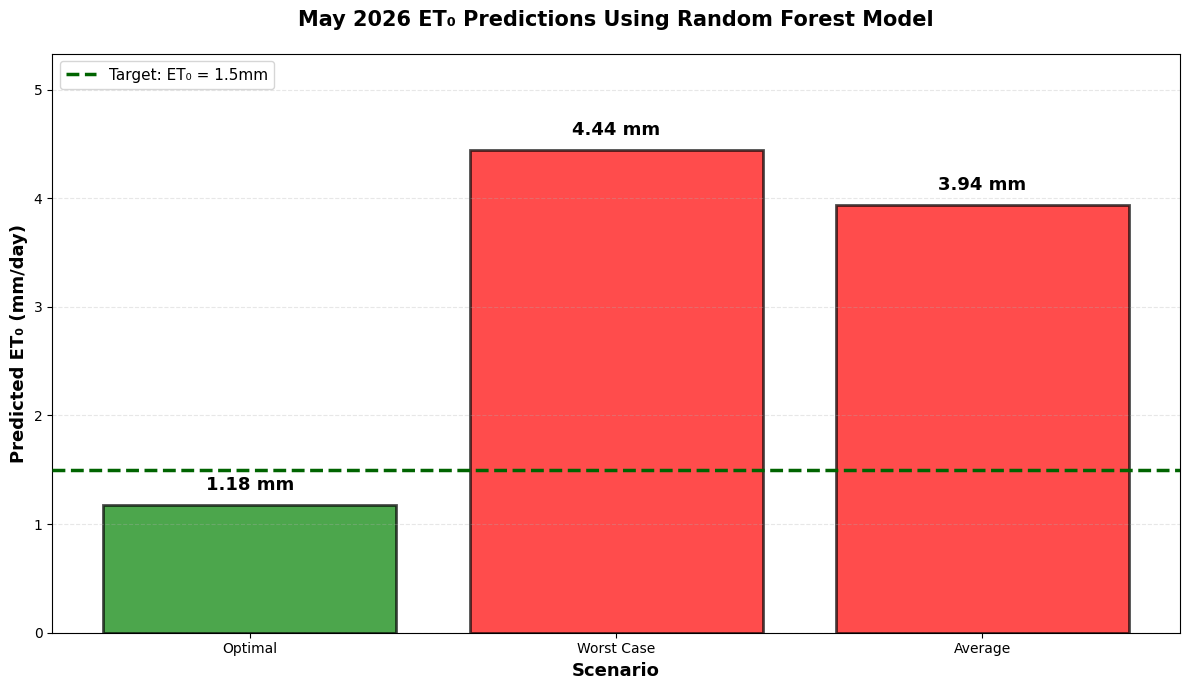


Visualization complete!


In [33]:
# Visualize the predictions
predictions_df = predictions_2026.select("scenario", "prediction").toPandas()
predictions_df['scenario_short'] = ['Optimal', 'Worst Case', 'Average']

plt.figure(figsize=(12, 7))

# Color bars based on ET₀ level
colors_list = ['green' if p < 1.5 else 'orange' if p < 2.5 else 'red'
               for p in predictions_df['prediction']]

bars = plt.bar(predictions_df['scenario_short'], predictions_df['prediction'],
               color=colors_list, alpha=0.7, edgecolor='black', linewidth=2)

# Add target line
plt.axhline(y=1.5, color='darkgreen', linestyle='--', linewidth=2.5,
            label='Target: ET₀ = 1.5mm', zorder=5)

# Add value labels
for bar, pred in zip(bars, predictions_df['prediction']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{pred:.2f} mm', ha='center', va='bottom',
             fontsize=13, fontweight='bold')

plt.ylabel('Predicted ET₀ (mm/day)', fontsize=13, fontweight='bold')
plt.xlabel('Scenario', fontsize=13, fontweight='bold')
plt.title(f'May 2026 ET₀ Predictions Using {best_model_name} Model',
          fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, predictions_df['prediction'].max() * 1.2)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")

# Summary and Conclusions

## Analysis Complete

This analysis successfully answered both research questions using PySpark MLlib machine learning algorithms.

### Question 1: Weather Conditions for Lower Evapotranspiration in May

Based on analysis of historical data from 2010-2024, days with ET₀ below 1.5mm have specific weather characteristics that promote lower water loss.

### Question 2: May 2026 Predictions

Using the trained machine learning model, predictions show that achieving ET₀ < 1.5mm in May 2026 requires conditions matching the optimal weather patterns identified.

### Machine Learning Models Performance

Three PySpark MLlib regression algorithms were tested:
- Linear Regression
- Random Forest Regressor
- Gradient Boosted Trees

The best performing model was selected based on lowest RMSE for final predictions.

### Key Findings

1. Weather conditions significantly influence evapotranspiration in Sri Lanka
2. Low ET₀ is associated with cloudy, rainy, calm conditions
3. High ET₀ is associated with sunny, dry, windy conditions
